In [3]:
import data_setup
import torchvision
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
weights = torchvision.models.GoogLeNet_Weights.DEFAULT
model = torchvision.models.googlenet(weights=weights).to(device)
model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [5]:
from torchinfo import summary

summary(model=model, input_size=(1, 3, 224, 224), col_names=['input_size', 'output_size', 'num_params', 'trainable'], col_width=20, row_settings=['var_names'])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
GoogLeNet (GoogLeNet)                    [1, 3, 224, 224]     [1, 1000]            --                   True
├─BasicConv2d (conv1)                    [1, 3, 224, 224]     [1, 64, 112, 112]    --                   True
│    └─Conv2d (conv)                     [1, 3, 224, 224]     [1, 64, 112, 112]    9,408                True
│    └─BatchNorm2d (bn)                  [1, 64, 112, 112]    [1, 64, 112, 112]    128                  True
├─MaxPool2d (maxpool1)                   [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
├─BasicConv2d (conv2)                    [1, 64, 56, 56]      [1, 64, 56, 56]      --                   True
│    └─Conv2d (conv)                     [1, 64, 56, 56]      [1, 64, 56, 56]      4,096                True
│    └─BatchNorm2d (bn)                  [1, 64, 56, 56]      [1, 64, 56, 56]      128                  True
├─BasicConv2d (c

In [6]:
from torch import nn

model.fc = nn.Linear(in_features=1024, out_features=8, bias=True).to(device)

In [7]:
summary(model=model, input_size=(1, 3, 224, 224), col_names=['input_size', 'output_size', 'num_params', 'trainable'], col_width=20, row_settings=['var_names'])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
GoogLeNet (GoogLeNet)                    [1, 3, 224, 224]     [1, 8]               --                   True
├─BasicConv2d (conv1)                    [1, 3, 224, 224]     [1, 64, 112, 112]    --                   True
│    └─Conv2d (conv)                     [1, 3, 224, 224]     [1, 64, 112, 112]    9,408                True
│    └─BatchNorm2d (bn)                  [1, 64, 112, 112]    [1, 64, 112, 112]    128                  True
├─MaxPool2d (maxpool1)                   [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
├─BasicConv2d (conv2)                    [1, 64, 56, 56]      [1, 64, 56, 56]      --                   True
│    └─Conv2d (conv)                     [1, 64, 56, 56]      [1, 64, 56, 56]      4,096                True
│    └─BatchNorm2d (bn)                  [1, 64, 56, 56]      [1, 64, 56, 56]      128                  True
├─BasicConv2d (c

In [8]:
model.load_state_dict(torch.load("./googlenet_multi_77.pth"))

<All keys matched successfully>

In [9]:
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
manual_tranforms = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), normalize])

train_dir = "./multipvp_midalgo_640_15_2/train"
test_dir = "./multipvp_midalgo_640_15_2/test"

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir, test_dir=test_dir, transform=manual_tranforms, batch_size=8)

In [10]:
device, train_dataloader, test_dataloader, class_names

('cuda',
 ['baseplate',
  'major_capsid',
  'major_tail',
  'minor_capsid',
  'minor_tail',
  'other',
  'portal',
  'tail_fiber'])

In [11]:
import torchmetrics

In [12]:
accuracy = torchmetrics.classification.Accuracy(task="MULTICLASS", num_classes=len(class_names)).to(device)
f1 = torchmetrics.classification.F1Score(task="MULTICLASS", num_classes=len(class_names)).to(device)  # Provide the number of classes in your dataset
recall = torchmetrics.classification.Recall(task="MULTICLASS", num_classes=len(class_names)).to(device)  # Provide the number of classes in your dataset

model.eval()
for data in test_dataloader:
    images, labels = data
    images = images.to(device)  # Move images to device
    labels = labels.to(device)  # Move labels to device

    # Ensure both images and labels are on the same device before inference
    with torch.no_grad():
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)

        # Update metrics
        accuracy.update(predicted, labels)
        f1.update(predicted, labels)
        recall.update(predicted, labels)

test_accuracy = accuracy.compute()
test_f1 = f1.compute()
test_recall = recall.compute()

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test F1 Score: {test_f1 * 100:.2f}%")
print(f"Test Recall: {test_recall * 100:.2f}%")

Test Accuracy: 76.37%
Test F1 Score: 76.37%
Test Recall: 76.37%


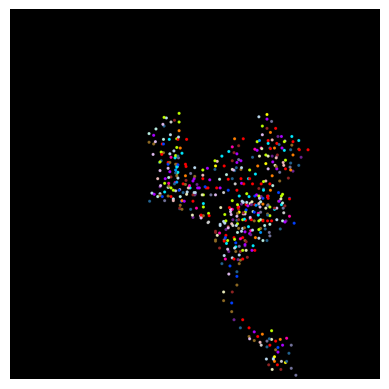

In [19]:
from PIL import Image
import matplotlib.pyplot as plt

test_image = './multipvp_midalgo_640_15_2/test/portal/NP_046899.1_len_530.png'
image = Image.open(test_image)

plt.imshow(image)
plt.axis('off')
plt.show()



In [20]:
transformed_image = manual_tranforms(image)
transformed_image = transformed_image.unsqueeze(0)


model.eval()
with torch.no_grad():
    output = model(transformed_image.to(device))
predicted_probabilities = torch.softmax(output, dim=1)
predicted_class = torch.argmax(predicted_probabilities, dim=1)

class_names[predicted_class]

'portal'